In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import json
import elasticsearch
import string
import re
import math
import os
import numpy as np
from collections import Counter

In [2]:
QUERY_TRAIN_FILEPATH = 'datasets\DBpedia\smarttask_dbpedia_train.json'

In [3]:
stop_words = set(['a', 'an', 'and', 'are', 'as', 'at', 'be', 'but', 'by', 'for', 'if', 'in', 'into', 'is', 'it', 'no', 'not', 'of', 'on', 'or', 'such', 'that', 'the', 'their', 'then', 'there', 'these', 'they', 'this', 'to', 'was', 'will', 'with'])
print(stop_words) # Default in ElasticSearch

{'then', 'not', 'and', 'for', 'a', 'will', 'if', 'by', 'these', 'but', 'in', 'was', 'an', 'of', 'on', 'it', 'the', 'at', 'are', 'such', 'no', 'or', 'that', 'to', 'there', 'with', 'this', 'as', 'be', 'into', 'is', 'they', 'their'}


In [4]:
def preprocess(text):
    """Preprocess some query, lower, remove punctuation stuff, stopwords, etc."""
    text = text.strip().lower()
    text = text.replace('_', ' ').replace('-', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation stuff.
    text = re.sub('\s\s+', ' ', text).split(' ') # Replace consequtive whitespace with a single space.
    return ' '.join([v for v in text if not v in stop_words]).strip()

In [5]:
def load_train_queries(filepath):
    """
    Load training queries from a file. 
    Returns a dictoinary with queryID as key and corresponding query, category and type.
    """
    query_dicts = {}
    queries = None
    with open(filepath, "r") as f:
        queries = f.read()
    
    for query in json.loads(queries):
        try:
            qID, qText, qCat, qType = query["id"].lower(), query["question"].lower(), query["category"].lower(), ' '.join(query["type"]).lower()
            if not 'dbo:' in qType: # Skip queries without a dbo: type.
                continue
            query_dicts[qID] = {"query": preprocess(qText), "category": qCat, "type": qType.replace('dbo:', '')}
        except Exception as e:
            # print("Query: {}\n\tThrew an exception: {}\n".format(query, e))
            continue
    return query_dicts

In [6]:
training_queries = load_train_queries(QUERY_TRAIN_FILEPATH)
print("# training queries:", len(training_queries), "\n\tExample key 'dbpedia_17655' returns:", training_queries['dbpedia_17655'])

# training queries: 9557 
	Example key 'dbpedia_17655' returns: {'query': 'what town birthplace joseph greenberg', 'category': 'resource', 'type': 'city settlement populatedplace place location'}


In [7]:
def loadDBPediaTypes():
    kv = {}
    max_depth = 0
    with open('./evaluation/dbpedia/dbpedia_types.tsv', 'r') as f:
        for i, line in enumerate(f):
            if i == 0: # Skip header
                continue
            line = line.strip().lower().split('\t')
            if len(line) != 3:
                continue
            type_name, depth, parent_type = line[0].split(':')[-1], int(line[1]), line[-1].split(':')[-1]
            if (len(type_name) == 0) or (len(parent_type) == 0):
                continue
            kv[type_name] = {'depth':depth, 'parent':parent_type}
            max_depth = max(depth, max_depth)
    return kv, max_depth

def getTypeHierarchy(kv, items, target):
    if not target in kv:
        return
    items.append(target)
    getTypeHierarchy(kv, items, kv[target]['parent'])

def buildDBPediaTypeHierarchy(kv, target, reverse=True):
    items = [] # List of types, representing the hierarchy of the types related to the target.
    getTypeHierarchy(kv, items, target)
    if reverse:
        return items[::-1] # Reverse the order to return the correct hierarchy where the first item = top level.
    return items

def cacheDBPediaPaths():
    """Simplify Evaluation Path Computations"""
    for k in type_hierarchy.keys():
        type_hierarchy[k]['path'] = buildDBPediaTypeHierarchy(type_hierarchy, k, False)

In [8]:
type_hierarchy, max_depth = loadDBPediaTypes()
cacheDBPediaPaths()
print(list(type_hierarchy.keys())[:4], 'Max Depth', max_depth)

['basketballleague', 'naturalevent', 'province', 'lunarcrater'] Max Depth 7


In [9]:
def read_result_from_file(file):
    result = {}
    with open('./results/{}.csv'.format(file), 'r') as f:
        for line in f:
            line = line.strip().split(',')
            if len(line) != 2:
                continue
            result[line[0]] = [v for v in line[-1].split(' ') if len(v) > 0]
    return result

In [10]:
def relevancy_frequency(result):
    items = [0, 0, 0]
    for qId, obj in training_queries.items():     
        if qId not in result:
            continue

        qTypes = obj['type'].split(' ')
        if len(qTypes) == 0:
            continue
            
        type_relevancy = {}        
        for typ in qTypes:
            if not typ in type_hierarchy:
                continue
            hierarchy = buildDBPediaTypeHierarchy(type_hierarchy, typ)
            for v in hierarchy:
                type_relevancy[v] = 1 # Relevant, its in the same hierarchy but in a diff pos.            

        for typ in qTypes:
            type_relevancy[typ] = 2 # This is the type we want. Give it the highest weight.

        if len(type_relevancy) == 0:
            continue
            
        for instanceType in result[qId]:
            relevancy = 0 # Default = not relevant
            if instanceType in type_relevancy:
                relevancy = type_relevancy[instanceType]
            elif instanceType in type_hierarchy:                
                relevancy = buildDBPediaTypeHierarchy(type_hierarchy, instanceType)
                relevancy = max([(1 if (t in type_relevancy) else 0) for t in relevancy] + [0])
            items[relevancy] += 1
            
    return items

In [11]:
res_advanced_pntwse = read_result_from_file('advanced')
res_word2vec = read_result_from_file('advanced_word2vec')
res_baseline = read_result_from_file('baseline')

In [12]:
relevancy_frequency(res_advanced_pntwse)

[17745, 22223, 55611]

In [30]:
mat = np.array([
    relevancy_frequency(res_baseline),
    relevancy_frequency(res_word2vec),
    relevancy_frequency(res_advanced_pntwse)
])
mat

array([[53135, 25964, 16573],
       [46631, 27898, 21145],
       [17745, 22223, 55611]])

In [31]:
perc = []
for v in mat:
    perc.append((v/v.sum()).tolist())

In [32]:
perc

[[0.5553871561167322, 0.27138556735513003, 0.1732272765281378],
 [0.4873946944833497, 0.2915943725568075, 0.2210109329598428],
 [0.18565793741303005, 0.23250923319976147, 0.5818328293872085]]

In [20]:
for v in mat:
    print(v, v.sum())
high = np.max(v)
barWidth = 0.15
BIN = ['Not Relevant', 'Partially Relevant', 'Relevant']
COLOR = ['#5ac95f', '#687f2d', '#2d7f5e']

[53135 25964 16573] 95672
[46631 27898 21145] 95674
[17745 22223 55611] 95579


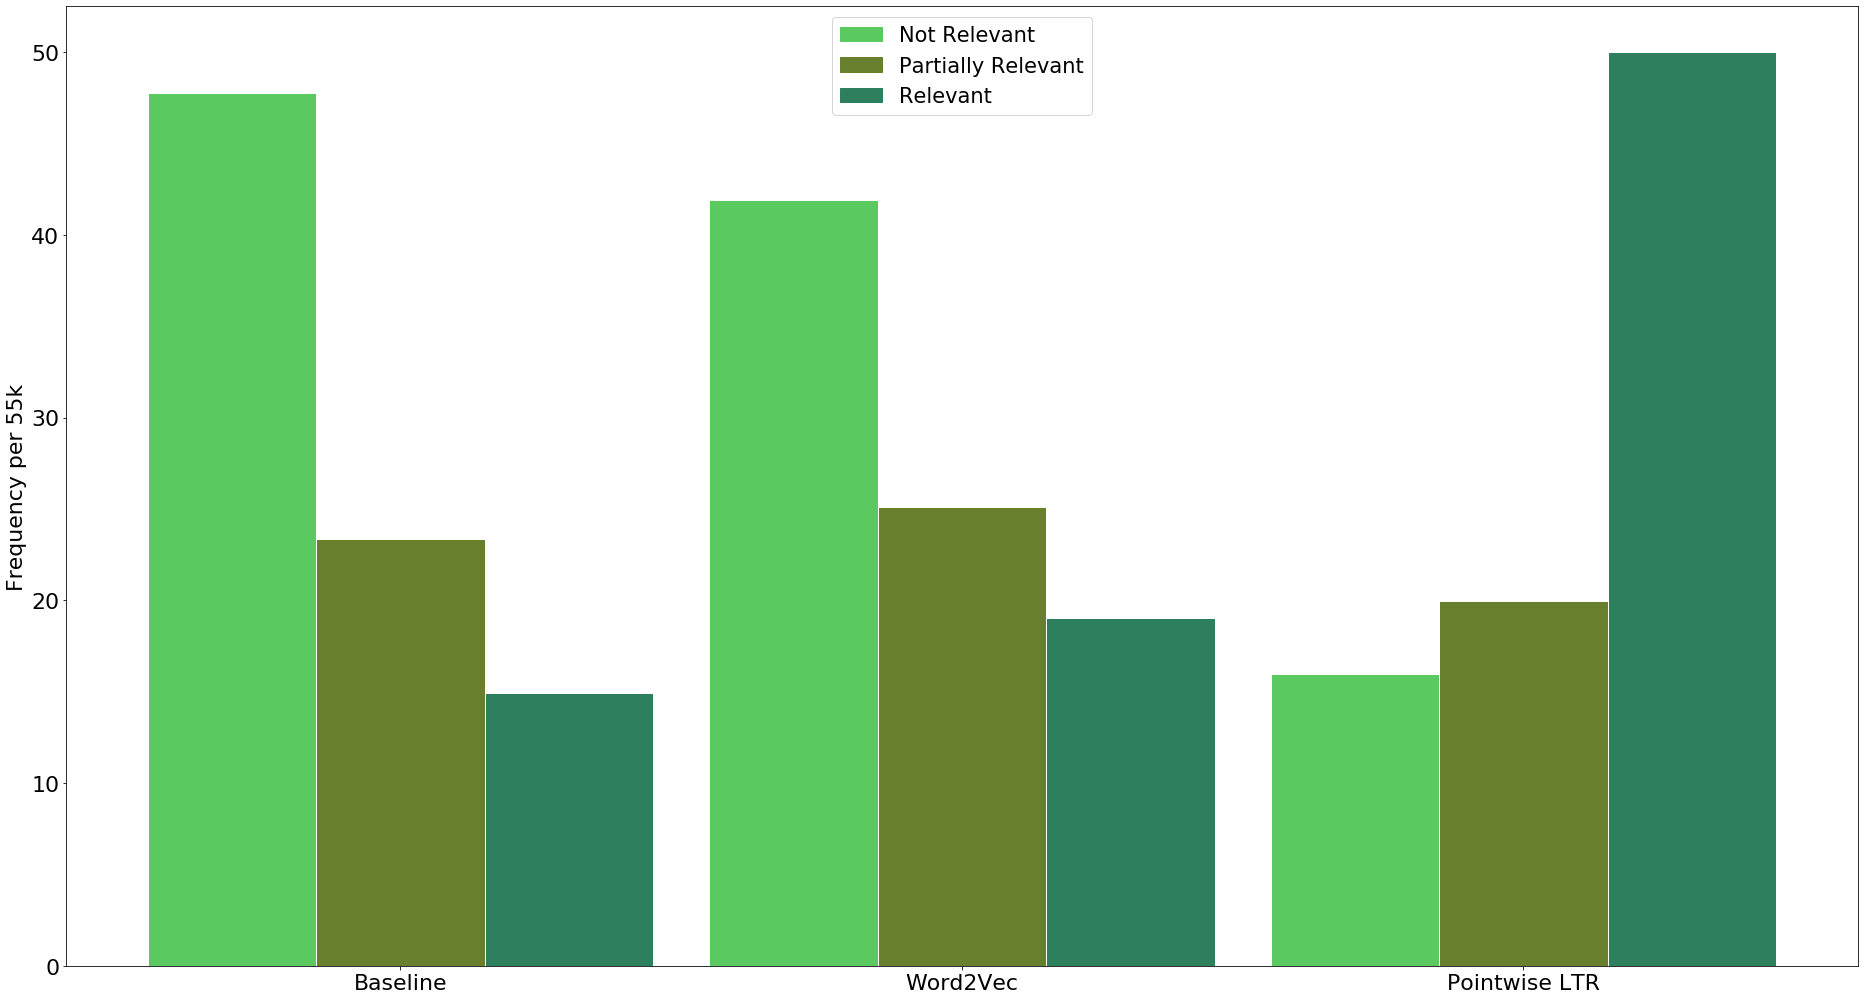

In [21]:
fig, ax = plt.subplots(1, figsize=(26,14), tight_layout=True)
pos = np.array([0, barWidth, barWidth*2])
xticks = []

for j, vec in enumerate(mat):
    height = (vec / high) * 50.0
    ax.bar(pos, height, color=COLOR, width=barWidth, edgecolor='white')
    xticks.append(pos[1])
    pos = pos + (barWidth*3+0.05)

ax.set_ylabel('Frequency per 55k', fontsize=22)
#ax.set_title('Relevancy Histogram', fontsize=25)
plt.xticks(xticks, ['Baseline', 'Word2Vec', 'Pointwise LTR'], fontsize=22)
plt.yticks(fontsize=22)

plt.legend([plt.Rectangle((0,0),1,1,color=c) for c in COLOR], BIN, fontsize=21)
plt.tight_layout()
#plt.savefig('./fig/relevancy_histogram.png', transparent=False, bbox_inches='tight')
plt.show()